# Homework Problem: Anthony Smith (Aiyagari Economy)
## Jincheng(Eric) Huang

There is a measure one of consumers and a typical consumer solves:
$$
v(k, \epsilon ; \overline{k})=\max _{k^{\prime}}\left[U\left(r(\overline{k})k+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right)+\beta E_{\epsilon^{\prime} | \epsilon} v\left(k^{\prime}, \epsilon^{\prime} ; \overline{k}\right)\right]
$$
    subject to $k' \geq 0$, where $k$ is individual capital, $\bar{k}$ is aggregate capital and $\epsilon$ is the consumer's employment status: $\epsilon \in \{\epsilon_1, \epsilon_2\}$, with $\epsilon_1 = 1$ (employed) and $\epsilon_2 = 0$ (unemployed).

## 1. Characterizing Equations
The FOC of the consumer's problem is:
$$
-U'\left(r(\overline{k})+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right) + 
\beta E_{\epsilon' | \epsilon} v_{k'}\left(k',\epsilon';\overline{k} \right) = 0
$$
The envelope condition is:
$$
v_k (k,\epsilon,\overline{k}) = U'\left(r(\overline{k})k+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right)
\left(r(\overline{k})+1-\delta \right)
$$

Combining yields the intertemporal Euler equation:
$$
U'\left(r(\overline{k})k+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right) = 
\beta E_{\epsilon' | \epsilon} U'\left(r(\overline{k'})k'+w(\overline{k'}) \epsilon'+(1-\delta) k'-k'^{\prime}\right)
\left(r(\overline{k'})+1-\delta \right)
$$

## 2. Solve for Policy Functions
The pricing functions $r(\overline{k})=\alpha \overline{k}^{\alpha-1}(1-u)^{1-\alpha}$ and $w(\overline{k})=(1-\alpha) \overline{k}^{\alpha}(1-u)^{-\alpha}$, where aggregate labor supply is equal to $1-u$.

Let a period be one year and set $u(c) = \log(c), \beta=0.96, \delta=0.06$, and $\alpha=0.36$.

Given the utility function above, the intertemporal Euler equation can be expressed as:
$$
1/\left(r(\overline{k})k+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right) = \beta \left(r(\overline{k'})+1-\delta \right) E_{\epsilon' | \epsilon} \left[ 1/\left(r(\overline{k'})k'+w(\overline{k'}) \epsilon'+(1-\delta) k'-k'^{\prime}\right) \right]
$$

Therefore
$$
k = 1/ \left(r(\overline{k}) + 1-\delta \right) \left\{ 1/ \left[\beta \left(r(\overline{k'})+1-\delta \right) E_{\epsilon' | \epsilon} 1/\left(r(\overline{k'})k'+w(\overline{k'}) \epsilon'+(1-\delta) k'-k'^{\prime}\right) \right]  - w(\overline{k})\epsilon + k' \right\}
$$

I use the endogenous grid method from Carroll (2006) to calculate the policy function below.

In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy import interpolate
import matplotlib.pyplot as plt

In [169]:
r = lambda α,k,u: α*k**(α-1)*(1-u)**(1-α)
w = lambda α,k,u: (1-α)*k**(α)*(1-u)**(-α)
u = lambda c: np.log(c)
uprime = lambda c: 1/c

def Euler_solve_k(functions,parameters,states,klevels):
    r,w,gk = functions
    α,β,δ,ur = parameters
    iϵ,k_grid,ϵ_states,ϵ_P = states
    kp,k_bar,kbarp = klevels
    
    ikp = np.where(k_grid==kp)[0]
    nk, nϵ = len(k_grid), len(ϵ_states)
    
    E_Vk = 0
    for iϵp,ϵp in enumerate(ϵ_states):
        E_Vk = E_Vk + ϵ_P[iϵ,iϵp] * 1/(r(α,kbarp,ur)*kbarp + w(α,kbarp,ur)*ϵp +(1-δ)*kp - gk[iϵp*nk+ikp])
    k = 1/(r(α,kbarp,ur)+1-δ) * (1/(β*(r(α,kbarp,ur)+1-δ)*E_Vk) -w(α,kbarp,ur)*ϵ_states[iϵ] + kp)
    return k

def EGM(functions,parameters,states):
    r,w,u = functions
    α,β,δ,ur = parameters
    k_grid,k_bar,ϵ_states,ϵ_P = states
    
    nk,nϵ = len(k_grid),len(ϵ_states)
    gk = np.ones((nϵ,1)).dot(k_grid.reshape(1,nk)).reshape(nϵ*nk,)
    V = np.zeros(nϵ*nk,)
    max_diff = np.inf
    tol = 1e-6
    niter = 1
    
    print('EGM for policy function:')
    
    while max_diff > tol:
        # A vector for expected continuation value. Each capital value stands for k'
        ev = np.zeros((nϵ*nk,))
        for ikp in range(nk):
            idxp = np.arange(ikp,nϵ*nk+ikp,nk)
            for iϵ in range(nϵ):            
                idx = iϵ*nk + ikp 
                ev[idx] = ev[idx] + ϵ_P[iϵ,:].dot(V[idxp])
        
        k_end, V_end, V_new, gk = np.zeros(nϵ*nk,), np.zeros(nϵ*nk,), np.zeros(nϵ*nk,), np.zeros(nϵ*nk,)
        
        for iϵ,ϵ_val in enumerate(ϵ_states):
            grid_range = np.arange(iϵ*nk,iϵ*nk+nk,1)
            
            for ikp,kp in enumerate(k_grid):
                idxp = iϵ*nk + ikp 
                k = Euler_solve_k((r,w,gk),(α,β,δ,ur),(iϵ,k_grid,ϵ_states,ϵ_P),(kp,k_bar,k_bar))
                k_end[idxp] = k
                c = r(α,k_bar,ur)*k + w(α,k_bar,ur)*ϵ_val + (1-δ)*k - kp
                V_end[idxp] = u(c) + β*ev[idxp]
                
            V_end_interp = interpolate.interp1d(k_end[grid_range],V_end[grid_range],fill_value='extrapolate')
            gk_interp = interpolate.interp1d(k_end[grid_range],k_grid,fill_value='extrapolate')
            
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik
                V_new[idx] = V_end_interp(k)
                gk[idx] = max(gk_interp(k),0)
        
        max_diff = max(np.abs(V_new-V))
        V = V_new.copy()
        
        if niter == 1 or niter % 50 == 0:
            print('   Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1
    return V,gk

def VFI(functions,parameters,states):
    r,w,u = functions
    α,β,δ,ur = parameters
    k_grid,k_bar,ϵ_states,ϵ_P = states
    
    nk,nϵ = len(k_grid),len(ϵ_states)
    gk = np.ones((nϵ,1)).dot(k_grid.reshape(1,nk)).reshape(nϵ*nk,)
    V = np.zeros(nϵ*nk,)
    max_diff = np.inf
    tol = 1e-6
    niter = 1
    
    while max_diff > 1e-6:
        # A vector for expected continuation value. Each capital value stands for k'
        ev = np.zeros((nϵ*nk,))
        for ikp in range(nk):
            idxp = np.arange(ikp,nϵ*nk+ikp,nk)
            for iϵ in range(nϵ):            
                idx = iϵ*nk + ikp 
                ev[idx] = ev[idx] + ϵ_P[iϵ,:].dot(V[idxp])
                
        V_new = np.zeros(nϵ*nk,)
        
        for iϵ,ϵ_val in enumerate(ϵ_states):
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik
                
                if niter % 5 == 1 :
                    vv = -np.inf
                    for ikp,kp in enumerate(k_grid):
                        idxp = iϵ*nk + ikp
                        c = r(α,k_bar,ur)*k + w(α,k_bar,ur)*ϵ_val + (1-δ)*k - kp
                        if c<=0:
                            break
                        else:
                            value = u(c) + β*ev[idxp]
                            if value > vv:
                                vv = value
                                gk[idx] = kp
                                V_new[idx] = value
                else:
                    kp = gk[idx]
                    idxp = iϵ*nk + np.where(k_grid==kp)[0]
                    c = r(α,k_bar,ur)*k + w(α,k_bar,ur)*ϵ_val + (1-δ)*k - kp 
                    V_new[idx] = u(c) + β*ev[idxp]
        
        max_diff = max(np.abs(V_new-V))
        V = V_new.copy()
        
        if niter == 1 or niter % 50 == 0:
            print('   Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1
    return V,gk

In [174]:
# Model parameters
β = .96
δ = .06
α = .36
nk = 150
ur_ss = .1      # target unemployment rate at 10%
ϵ_ee = .9       # probability of staying employed in the next period

# Functions for calibration
def calculate_ur_ss(ϵ_uu,ϵ_ee):
    P = np.array([[ϵ_uu,1-ϵ_uu],[1-ϵ_ee,ϵ_ee]])
    mu = np.array([.5,.5])
    diff = np.inf
    
    while diff > 1e-8:
        mu_new = mu.dot(P)
        diff = max(np.abs(mu_new-mu))
        mu = mu_new.copy()
        
    return mu[0]

# Calibrate the probability of staying unemployed to match the unemployment rate target
ϵ_uu = fsolve(lambda ϵ_uu,ϵ_ee: calculate_ur_ss(ϵ_uu,ϵ_ee)-ur_ss,.1,args=(ϵ_ee))
ϵ_states = np.array([0.,1.])
ϵ_P = np.array([[ϵ_uu,1-ϵ_uu],[1-ϵ_ee,ϵ_ee]])
nϵ = len(ϵ_states)

# Generate a grid for capital
k_grid = np.linspace(0.001,40,nk).reshape(nk,)

In [173]:
V,gk = VFI((r,w,u),(α,β,δ,ur_ss),(k_grid,k_ss_rep,ϵ_states,ϵ_P))

   Iteration 1: max diff = 10.0858091
   Iteration 50: max diff = 0.1130942
   Iteration 100: max diff = 0.0130869
   Iteration 150: max diff = 0.0016512
   Iteration 200: max diff = 0.0002136
   Iteration 250: max diff = 0.0000277
   Iteration 300: max diff = 0.0000036


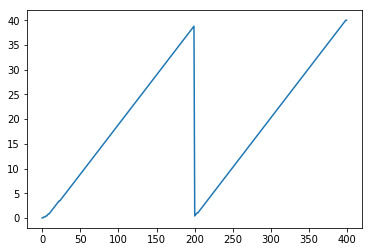

In [175]:
plt.plot(gk)

## 3. Solve for the Steady State Distribution
Now that I have the policy function, I use the following steps to calculate the steady state:
1. Guess on $\overline{k}$, the aggregate capital level. Here I use the capital level from the representative-agent economy.
2. Use the policy function and the law of motion for $\epsilon$ to calculate the state transition matrix $P(k_i \epsilon_j,k_m \epsilon_n)$.
3. Find the invariant distribution $\mu(k,\epsilon)$ associated with the transition matrix.
4. Integrate each capital level on the grid based on the density function $\mu(k,\epsilon)$ to get $\hat{\overline{k}}$.
5. If $\hat{\overline{k}}$ is close to $\overline{k}$, stop. Otherwise, update $\overline{k}$ and repeat from step 1.

In [180]:
# Calculate aggregate capital in a rep. agent economy
f = lambda k,α,β,ur: 1/β-1+δ-r(α,k,ur)
k_ss_rep = fsolve(f,.1,args=(α,β,ur_ss))  # steady state capital in rep agent case

def gen_transition(gk,k_grid,ϵ_P):
    nϵ = ϵ_P.shape[0]
    nk = np.int(len(gk)/nϵ)
    
    P = np.zeros((nϵ*nk,nϵ*nk))
    for iϵ in range(nϵ):
        for ik in range(nk):
            i = iϵ*nk + ik
            kp = gk[i]
            ikp1 = min(j for j,kj in enumerate(k_grid) if kj>=kp)
            ikp2 = max(j for j,kj in enumerate(k_grid) if kj<=kp)
            
            if ikp1 != ikp2:
                coeff1 = (k_grid[ikp1]-kp)/(k_grid[ikp1]-k_grid[ikp2])
                coeff2 = (kp-k_grid[ikp2])/(k_grid[ikp1]-k_grid[ikp2])
            else:
                coeff1 = 1
                coeff2 = 1
                
            kp_distribution = np.zeros((nk,1))
            kp_distribution[ikp1] = coeff2
            kp_distribution[ikp2] = coeff1
            P[i,:] = ϵ_P[iϵ,:].reshape(nϵ,1).dot(kp_distribution.T).reshape(nϵ*nk,)   
    return P

In [182]:
niter = 1
diff = np.inf
k_bar = k_ss_rep
while diff > 1e-6:
    V,gk = VFI((r,w,u),(α,β,δ,ur_ss),(k_grid,k_bar,ϵ_states,ϵ_P))
    P = gen_transition(gk,k_grid,ϵ_P)
    μ = np.ones((nϵ*nk,))/(nϵ*nk)
    max_diff = np.inf
    while max_diff > 1e-8:
        μ_new = μ.dot(P)
        max_diff = max(np.abs(μ_new-μ))
        μ = μ_new.copy()
    
    k_grid_long = np.ones((2,1)).dot(k_grid.reshape((1,nk))).reshape((nk*nϵ,1))
    k_bar_hat = μ.dot(k_grid_long)
    diff = np.abs(k_bar_hat - k_bar)
    print('Aggregate k iteration %d: diff = %1.5f' % (niter,diff))
    print(k_bar_hat)
    niter = niter + 1
    k_bar = 0.8*k_bar + 0.2*k_bar_hat

   Iteration 1: max diff = 10.0858091
   Iteration 50: max diff = 0.1139351
   Iteration 100: max diff = 0.0130189
   Iteration 150: max diff = 0.0015478
   Iteration 200: max diff = 0.0001828
   Iteration 250: max diff = 0.0000211
   Iteration 300: max diff = 0.0000024
Aggregate k iteration 1: diff = 9.08102
[15.57108204]
   Iteration 1: max diff = 10.5265246
   Iteration 50: max diff = 0.0757213
   Iteration 100: max diff = 0.0072554
   Iteration 150: max diff = 0.0009273
   Iteration 200: max diff = 0.0001204
   Iteration 250: max diff = 0.0000156
   Iteration 300: max diff = 0.0000020
Aggregate k iteration 2: diff = 6.71838
[1.58787943]
   Iteration 1: max diff = 10.1993327
   Iteration 50: max diff = 0.0995992
   Iteration 100: max diff = 0.0088941
   Iteration 150: max diff = 0.0010279
   Iteration 200: max diff = 0.0001246
   Iteration 250: max diff = 0.0000147
   Iteration 300: max diff = 0.0000018
Aggregate k iteration 3: diff = 4.66540
[2.29718468]
   Iteration 1: max diff = 

KeyboardInterrupt: 